# BASE - 1719

Information:
* Periodo: 2017-2019
* Objetivo: predicción de pobreza

## 1. Load data and Libraries

In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
import pandas as  pd
import numpy as np
import pickle
import joblib

In [3]:
# import variables_nombres as vn

In [4]:
path = r'..\..\..\input\prediction\preprocessed_data\base17_19_hogar.csv'
data = pd.read_csv( path )

In [5]:
data.shape

(10793, 194)

In [6]:
data[ 'pobreza' ].value_counts( normalize = True )

0    0.896507
1    0.103493
Name: pobreza, dtype: float64

In [7]:
data[ 'pobreza' ].value_counts()

0    9676
1    1117
Name: pobreza, dtype: int64

## 2. Split variables

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
dep_var    = [ 'pobreza' ]
other_vars = [ 'numpanh' ]
pred_vars  = [ col for col in data.columns if col not in dep_var and col not in other_vars ]

x_train, x_test, y_train, y_test = train_test_split( data[ pred_vars ], 
                                                     data[ 'pobreza' ], 
                                                     test_size = 0.3,
                                                     random_state = 2023 )

In [10]:
col1 = 'vars'
pred_vars_1719 = pd.DataFrame( { col1:pred_vars } )
pred_vars_1719.to_excel( r'..\..\..\extra\prediction\varlists\pred_vars_1719_hogar.xlsx' )

## 3. Resampling

#### 3.1 SMOTE TOMEK

In [11]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from collections import Counter 

os_us = SMOTETomek( random_state         = 2023, 
                    sampling_strategy    = 'all' )

x_train_smote_tomek, y_train_smote_tomek = os_us.fit_resample( x_train, y_train )

#### 3.2 SMOTE

In [12]:
os_us = SMOTE( random_state      = 2023, 
               sampling_strategy = 'all' )

x_train_smote, y_train_smote = os_us.fit_resample( x_train, y_train )

#### 3.3 Naive random sampling

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler( random_state = 2023 )

x_train_ros, y_train_ros = ros.fit_resample( x_train, y_train )

### 3.4. Check data and variables percentage

In [14]:
check_data      = np.zeros( ( 4, 4 ) )

check_data[ 0 ] = [ x_train.shape[ 0 ], x_train.shape[ 1 ], 
                    y_train.value_counts()[ 0 ], y_train.value_counts()[ 1 ] ]

check_data[ 1 ] = [ x_train_smote.shape[ 0 ], x_train_smote.shape[ 1 ], 
                    y_train_smote.value_counts()[ 0 ], y_train_smote.value_counts()[ 1 ] ]

check_data[ 2 ] = [ x_train_smote_tomek.shape[ 0 ], x_train_smote_tomek.shape[ 1 ],
                    y_train_smote_tomek.value_counts()[ 0 ], y_train_smote_tomek.value_counts()[ 1 ] ]

check_data[ 3 ] = [ x_train_ros.shape[ 0 ], x_train_ros.shape[ 1 ],
                    y_train_ros.value_counts()[ 0 ], y_train_ros.value_counts()[ 1 ] ]

colnames        = [ 'observaciones', 'variables', 'Nro. No', 'Nro. Si' ]

rownames        = [ 'Original',
                    'SMOTE',
                    'SOMTE Tomek',
                    'NRS' ]

table_check_data = pd.DataFrame( check_data, columns = colnames )
table_check_data.index = rownames
table_check_data

,observaciones,variables,Nro. No,Nro. Si
Original,7555.0,192.0,6775.0,780.0
SMOTE,13550.0,192.0,6775.0,6775.0
SOMTE Tomek,13524.0,192.0,6762.0,6762.0
NRS,13550.0,192.0,6775.0,6775.0


In [15]:
o_20 = 20*x_train.shape[ 1 ]/100
o_30 = 30*x_train.shape[ 1 ]/100
o_40 = 40*x_train.shape[ 1 ]/100

print( o_20, o_30, o_40, sep = '\n' )

38.4
57.6
76.8


## 4. Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score, f1_score, classification_report

In [17]:
%%time

# Set the model (Comentado)
rf_model = RandomForestClassifier( random_state = 2023,
                                   n_jobs = -1 )

# Define param grid (Comentado)
rf_param_grid = {
    'n_estimators': [ 250, 500, 1000 ],
    'max_features': [ 38, 58, 77 ],
    'max_depth': [ 10, 20, 30 ]
}

# Set up cross-validation strategy
cv = KFold( n_splits = 5, shuffle = True, random_state = 2023 )

# Grid search (Comentado)
rf_search_o = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid,
                            cv = cv,
                            n_jobs = -1 )

rf_search_s = GridSearchCV( estimator = rf_model,
                            param_grid = rf_param_grid,
                            cv = cv,
                            n_jobs = -1 )

rf_search_st = GridSearchCV( estimator = rf_model,
                             param_grid = rf_param_grid,
                             cv = cv,
                             n_jobs = -1 )

rf_search_nrs = GridSearchCV( estimator = rf_model,
                              param_grid = rf_param_grid,
                              cv = cv,
                              n_jobs = -1 )

# Fit different models (Comentado)
rf_search_o.fit( x_train, y_train )
rf_search_s.fit( x_train_smote, y_train_smote )
rf_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )
rf_search_nrs.fit( x_train_ros, y_train_ros )

# Print best params and best score (Comentado)
print( f'Original dataset: { rf_search_o.best_params_ }' )
print( f'SMOTE dataset: { rf_search_s.best_params_ }' )
print( f'SMOTE Tomek dataset: { rf_search_st.best_params_ }' )
print( f'NRS dataset: { rf_search_nrs.best_params_ }' )

# Select best params (Comentado)
rf_max_features_o   = rf_search_o.best_params_[ 'max_features' ] 
rf_n_estimators_o   = rf_search_o.best_params_[ 'n_estimators' ]
rf_max_depth_o      = rf_search_o.best_params_[ 'max_depth' ]

rf_max_features_s   = rf_search_s.best_params_[ 'max_features' ] 
rf_n_estimators_s   = rf_search_s.best_params_[ 'n_estimators' ]
rf_max_depth_s      = rf_search_s.best_params_[ 'max_depth' ] 

rf_max_features_st  = rf_search_st.best_params_[ 'max_features' ] 
rf_n_estimators_st  = rf_search_st.best_params_[ 'n_estimators' ]
rf_max_depth_st     = rf_search_st.best_params_[ 'max_depth' ] 

rf_max_features_nrs = rf_search_nrs.best_params_[ 'max_features' ] 
rf_n_estimators_nrs = rf_search_nrs.best_params_[ 'n_estimators' ]
rf_max_depth_nrs    = rf_search_nrs.best_params_[ 'max_depth' ] 

Original dataset: {'max_depth': 10, 'max_features': 77, 'n_estimators': 500}
SMOTE dataset: {'max_depth': 30, 'max_features': 38, 'n_estimators': 500}
SMOTE Tomek dataset: {'max_depth': 30, 'max_features': 38, 'n_estimators': 250}
NRS dataset: {'max_depth': 30, 'max_features': 38, 'n_estimators': 250}
Wall time: 1h 2min 41s


In [18]:
# Train the optimal models
rf_optimal_model_o = RandomForestClassifier( max_features = rf_max_features_o, 
                                             n_estimators = rf_n_estimators_o,
                                             max_depth    = rf_max_depth_o,
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_s = RandomForestClassifier( max_features = rf_max_features_s, 
                                             n_estimators = rf_n_estimators_s,
                                             max_depth    = rf_max_depth_s,
                                             random_state = 2023,
                                             n_jobs = -1 )

rf_optimal_model_st = RandomForestClassifier( max_features = rf_max_features_st, 
                                              n_estimators = rf_n_estimators_st,
                                              max_depth    = rf_max_depth_st,                                             
                                              random_state = 2023,
                                              n_jobs = -1 )

rf_optimal_model_nrs = RandomForestClassifier( max_features = rf_max_features_nrs, 
                                               n_estimators = rf_n_estimators_nrs,
                                               max_depth    = rf_max_depth_nrs,
                                               random_state = 2023,
                                               n_jobs = -1 )

rf_optimal_model_o.fit( x_train, y_train )
rf_optimal_model_s.fit( x_train_smote, y_train_smote )
rf_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )
rf_optimal_model_nrs.fit( x_train_ros, y_train_ros )

# Apply over test set
y_rf_pred_class_o   = rf_optimal_model_o.predict( x_test )
y_rf_pred_prob_o    = rf_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_s   = rf_optimal_model_s.predict( x_test )
y_rf_pred_prob_s    = rf_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_st  = rf_optimal_model_st.predict( x_test )
y_rf_pred_prob_st   = rf_optimal_model_st.predict_proba( x_test )[ :, 1 ]

y_rf_pred_class_nrs = rf_optimal_model_nrs.predict( x_test )
y_rf_pred_prob_nrs  = rf_optimal_model_nrs.predict_proba( x_test )[ :, 1 ]

In [19]:
# Calculating clasiffication report
columns             = [ 'no', 'si' ]
rf_report_o         = classification_report( y_test, y_rf_pred_class_o, target_names = columns, output_dict = True )
rf_report_s         = classification_report( y_test, y_rf_pred_class_s, target_names = columns, output_dict = True )
rf_report_st        = classification_report( y_test, y_rf_pred_class_st, target_names = columns, output_dict = True )
rf_report_nrs       = classification_report( y_test, y_rf_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o   = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o      = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o    = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o   = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o      = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o    = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o       = accuracy_score( y_test, y_rf_pred_class_o )
log_loss_rf_o       = log_loss( y_test, y_rf_pred_class_o )
roc_auc_rf_o        = roc_auc_score( y_test, y_rf_pred_prob_o )
f1_score_rf_o       = f1_score( y_test, y_rf_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
rf_no_precision_s   = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s      = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s    = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s   = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s      = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s    = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s       = accuracy_score( y_test, y_rf_pred_class_s )
log_loss_rf_s       = log_loss( y_test, y_rf_pred_class_s )
roc_auc_rf_s        = roc_auc_score( y_test, y_rf_pred_prob_s )
f1_score_rf_s       = f1_score( y_test, y_rf_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st  = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st     = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st   = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st  = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st     = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st   = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st      = accuracy_score( y_test, y_rf_pred_class_st )
log_loss_rf_st      = log_loss( y_test, y_rf_pred_class_st )
roc_auc_rf_st       = roc_auc_score( y_test, y_rf_pred_prob_st )
f1_score_rf_st      = f1_score( y_test, y_rf_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
rf_no_precision_nrs = rf_report_nrs[ 'no' ][ 'precision' ]
rf_no_recall_nrs    = rf_report_nrs[ 'no' ][ 'recall' ]
rf_no_f1_score_nrs  = rf_report_nrs[ 'no' ][ 'f1-score' ]

rf_si_precision_nrs = rf_report_nrs[ 'si' ][ 'precision' ]
rf_si_recall_nrs    = rf_report_nrs[ 'si' ][ 'recall' ]
rf_si_f1_score_nrs  = rf_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_rf_nrs     = accuracy_score( y_test, y_rf_pred_class_nrs )
log_loss_rf_nrs     = log_loss( y_test, y_rf_pred_class_nrs )
roc_auc_rf_nrs      = roc_auc_score( y_test, y_rf_pred_prob_nrs )
f1_score_rf_nrs     = f1_score( y_test, y_rf_pred_class_nrs, average = 'macro' )

## 5. Boosted Trees

In [20]:
from xgboost import XGBClassifier

In [21]:
%%time

# Set the model (Comentrario) 
xgb_model = XGBClassifier( use_label_encoder = False, 
                           objective = 'binary:logistic', 
                           verbosity = 0,
                           learning_rate = 0.1,
                           random_state = 2023,
                           n_jobs = -1 )

# Define param grid (Comentrario)
xgb_param_grid = {
    'n_estimators': [ 250, 500, 1000 ],
    'max_features': [ 38, 58, 77 ],
    'max_depth': [ 1, 2 ]
}

# Set up cross-validation strategy
cv = KFold( n_splits = 5, shuffle = True, random_state = 2023 )

# Grid search (Comentrario)
xgb_search_o = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid,
                             cv = cv,
                             n_jobs = -1 )

xgb_search_s = GridSearchCV( estimator = xgb_model,
                             param_grid = xgb_param_grid,
                             cv = cv,
                             n_jobs = -1 )

xgb_search_st = GridSearchCV( estimator = xgb_model,
                              param_grid = xgb_param_grid,
                              cv = cv,
                              n_jobs = -1 )

xgb_search_nrs = GridSearchCV( estimator = xgb_model,
                               param_grid = xgb_param_grid,
                               cv = cv,
                               n_jobs = -1 )

# Fit different models (Comentrario)
xgb_search_o.fit( x_train, y_train )
xgb_search_s.fit( x_train_smote, y_train_smote )
xgb_search_st.fit( x_train_smote_tomek, y_train_smote_tomek )
xgb_search_nrs.fit( x_train_ros, y_train_ros )

# Print best params and best scores (Comentrario)
print( xgb_search_o.best_params_ )
print( xgb_search_s.best_params_ )
print( xgb_search_st.best_params_ )
print( xgb_search_nrs.best_params_ )

# Select best params (Comentrario)
xgb_max_features_o   = xgb_search_o.best_params_[ 'max_features' ] 
xgb_max_depth_o      = xgb_search_o.best_params_[ 'max_depth' ] 
xgb_n_estimators_o   = xgb_search_o.best_params_[ 'n_estimators' ] 

xgb_max_features_s   = xgb_search_s.best_params_[ 'max_features' ] 
xgb_max_depth_s      = xgb_search_s.best_params_[ 'max_depth' ] 
xgb_n_estimators_s   = xgb_search_s.best_params_[ 'n_estimators' ] 

xgb_max_features_st  = xgb_search_st.best_params_[ 'max_features' ] 
xgb_max_depth_st     = xgb_search_st.best_params_[ 'max_depth' ] 
xgb_n_estimators_st  = xgb_search_st.best_params_[ 'n_estimators' ] 

xgb_max_features_nrs = xgb_search_nrs.best_params_[ 'max_features' ] 
xgb_max_depth_nrs    = xgb_search_nrs.best_params_[ 'max_depth' ] 
xgb_n_estimators_nrs = xgb_search_nrs.best_params_[ 'n_estimators' ]

{'max_depth': 1, 'max_features': 38, 'n_estimators': 250}
{'max_depth': 2, 'max_features': 38, 'n_estimators': 500}
{'max_depth': 2, 'max_features': 38, 'n_estimators': 1000}
{'max_depth': 2, 'max_features': 38, 'n_estimators': 1000}
Wall time: 29min 29s


In [22]:
# Train the optimal model
xgb_optimal_model_o = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = 0.1,
                                     max_features = xgb_max_features_o,
                                     max_depth = xgb_max_depth_o,
                                     n_estimators = xgb_n_estimators_o,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_s = XGBClassifier( objective = 'binary:logistic', 
                                     verbosity = 0,
                                     learning_rate = 0.1,
                                     max_features = xgb_max_features_s,
                                     max_depth = xgb_max_depth_s,
                                     n_estimators = xgb_n_estimators_s,
                                     random_state = 2023,
                                     n_jobs = -1 )

xgb_optimal_model_st = XGBClassifier( objective = 'binary:logistic', 
                                      verbosity = 0,
                                      learning_rate = 0.1,
                                      max_features = xgb_max_features_st, 
                                      max_depth = xgb_max_depth_st,
                                      n_estimators = xgb_n_estimators_st,
                                      random_state = 2023,
                                      n_jobs = -1 )

xgb_optimal_model_nrs = XGBClassifier( objective = 'binary:logistic', 
                                       verbosity = 0,
                                       learning_rate = 0.1,
                                       max_features = xgb_max_features_nrs, 
                                       max_depth = xgb_max_depth_nrs,
                                       n_estimators = xgb_n_estimators_nrs,
                                       random_state = 2023,
                                       n_jobs = -1 )

xgb_optimal_model_o.fit( x_train, y_train )
xgb_optimal_model_s.fit( x_train_smote, y_train_smote )
xgb_optimal_model_st.fit( x_train_smote_tomek, y_train_smote_tomek )
xgb_optimal_model_nrs.fit( x_train_ros, y_train_ros )

# Apply over test set
y_xgb_pred_class_o   = xgb_optimal_model_o.predict( x_test )
y_xgb_pred_prob_o    = xgb_optimal_model_o.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_s   = xgb_optimal_model_s.predict( x_test )
y_xgb_pred_prob_s    = xgb_optimal_model_s.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_st  = xgb_optimal_model_st.predict( x_test )
y_xgb_pred_prob_st   = xgb_optimal_model_st.predict_proba( x_test )[ :, 1 ]

y_xgb_pred_class_nrs = xgb_optimal_model_nrs.predict( x_test )
y_xgb_pred_prob_nrs  = xgb_optimal_model_nrs.predict_proba( x_test )[ :, 1 ]

In [23]:
# Calculating clasiffication report
columns              = [ 'no', 'si' ]
xgb_report_o         = classification_report( y_test, y_xgb_pred_class_o, target_names = columns, output_dict = True )
xgb_report_s         = classification_report( y_test, y_xgb_pred_class_s, target_names = columns, output_dict = True )
xgb_report_st        = classification_report( y_test, y_xgb_pred_class_st, target_names = columns, output_dict = True )
xgb_report_nrs       = classification_report( y_test, y_xgb_pred_class_nrs, target_names = columns, output_dict = True )

# Calculating metrics for the original model
xgb_no_precision_o   = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o      = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o    = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o   = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o      = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o    = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o       = accuracy_score( y_test, y_xgb_pred_class_o )
log_loss_xgb_o       = log_loss( y_test, y_xgb_pred_class_o )
roc_auc_xgb_o        = roc_auc_score( y_test, y_xgb_pred_prob_o )
f1_score_xgb_o       = f1_score( y_test, y_xgb_pred_class_o, average = 'macro' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s   = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s      = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s    = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s   = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s      = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s    = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s       = accuracy_score( y_test, y_xgb_pred_class_s )
log_loss_xgb_s       = log_loss( y_test, y_xgb_pred_class_s )
roc_auc_xgb_s        = roc_auc_score( y_test, y_xgb_pred_prob_s )
f1_score_xgb_s       = f1_score( y_test, y_xgb_pred_class_s, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st  = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st     = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st   = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st  = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st     = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st   = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st      = accuracy_score( y_test, y_xgb_pred_class_st )
log_loss_xgb_st      = log_loss( y_test, y_xgb_pred_class_st )
roc_auc_xgb_st       = roc_auc_score( y_test, y_xgb_pred_prob_st )
f1_score_xgb_st      = f1_score( y_test, y_xgb_pred_class_st, average = 'macro' )

# Calculating metrics for the NRS model
xgb_no_precision_nrs = xgb_report_nrs[ 'no' ][ 'precision' ]
xgb_no_recall_nrs    = xgb_report_nrs[ 'no' ][ 'recall' ]
xgb_no_f1_score_nrs  = xgb_report_nrs[ 'no' ][ 'f1-score' ]

xgb_si_precision_nrs = xgb_report_nrs[ 'si' ][ 'precision' ]
xgb_si_recall_nrs    = xgb_report_nrs[ 'si' ][ 'recall' ]
xgb_si_f1_score_nrs  = xgb_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_xgb_nrs     = accuracy_score( y_test, y_xgb_pred_class_nrs )
log_loss_xgb_nrs     = log_loss( y_test, y_xgb_pred_class_nrs )
roc_auc_xgb_nrs      = roc_auc_score( y_test, y_xgb_pred_prob_nrs )
f1_score_xgb_nrs     = f1_score( y_test, y_xgb_pred_class_nrs, average = 'macro' )

## 6. Resultados Test

In [24]:
# Calculate Matthews Correlation Coefficient
from sklearn.metrics import matthews_corrcoef

mcc_rf_o           = matthews_corrcoef( y_test, y_rf_pred_class_o )
mcc_rf_s           = matthews_corrcoef( y_test, y_rf_pred_class_s )
mcc_rf_st          = matthews_corrcoef( y_test, y_rf_pred_class_st )
mcc_rf_nrs         = matthews_corrcoef( y_test, y_rf_pred_class_nrs )

mcc_xgb_o          = matthews_corrcoef( y_test, y_xgb_pred_class_o )
mcc_xgb_s          = matthews_corrcoef( y_test, y_xgb_pred_class_s )
mcc_xgb_st         = matthews_corrcoef( y_test, y_xgb_pred_class_st )
mcc_xgb_nrs        = matthews_corrcoef( y_test, y_xgb_pred_class_nrs )

In [25]:
table = np.zeros( ( 8, 10 ) )

table[ 0 ] = [ accuracy_rf_o, roc_auc_rf_o, f1_score_rf_o, mcc_rf_o, rf_no_precision_o, rf_no_recall_o, 
               rf_no_f1_score_o, rf_si_precision_o, rf_si_recall_o, rf_si_f1_score_o ]

table[ 1 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s, rf_si_precision_s, rf_si_recall_s, rf_si_f1_score_s ]

table[ 2 ] = [ accuracy_rf_st, roc_auc_rf_st, f1_score_rf_st, mcc_rf_st, rf_no_precision_st, rf_no_recall_st, 
               rf_no_f1_score_st, rf_si_precision_st, rf_si_recall_st, rf_si_f1_score_st ]

table[ 3 ] = [ accuracy_rf_nrs, roc_auc_rf_nrs, f1_score_rf_nrs, mcc_rf_nrs, rf_no_precision_nrs, rf_no_recall_nrs, 
               rf_no_f1_score_nrs, rf_si_precision_nrs, rf_si_recall_nrs, rf_si_f1_score_nrs ]

table[ 4 ] = [ accuracy_xgb_o, roc_auc_xgb_o, f1_score_xgb_o, mcc_xgb_o, xgb_no_precision_o, xgb_no_recall_o, 
               xgb_no_f1_score_o, xgb_si_precision_o, xgb_si_recall_o, xgb_si_f1_score_o ]

table[ 5 ] = [ accuracy_xgb_s, roc_auc_xgb_s, f1_score_xgb_s, mcc_xgb_s, xgb_no_precision_s, xgb_no_recall_s, 
               xgb_no_f1_score_s, xgb_si_precision_s, xgb_si_recall_s, xgb_si_f1_score_s ]

table[ 6 ] = [ accuracy_xgb_st, roc_auc_xgb_st, f1_score_xgb_st, mcc_xgb_st, xgb_no_precision_st, xgb_no_recall_st, 
               xgb_no_f1_score_st, xgb_si_precision_st, xgb_si_recall_st, xgb_si_f1_score_st ]

table[ 7 ] = [ accuracy_xgb_nrs, roc_auc_xgb_nrs, f1_score_xgb_nrs, mcc_xgb_nrs, xgb_no_precision_nrs, xgb_no_recall_nrs, 
               xgb_no_f1_score_nrs, xgb_si_precision_nrs, xgb_si_recall_nrs, xgb_si_f1_score_nrs ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",                   
                   "NRS. Random Forest", 
                   "O. Boosted Trees",                  
                   "S. Boosted Trees",                  
                   "ST. Boosted Trees",
                   "NRS. Boosted Trees" ]                  


table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Random Forest,0.897,0.770,0.490,0.090,0.897,0.999,0.945,0.600,0.018,0.035
S. Random Forest,0.886,0.766,0.544,0.133,0.903,0.978,0.939,0.337,0.095,0.148
ST. Random Forest,0.886,0.767,0.545,0.135,0.903,0.978,0.939,0.337,0.098,0.152
NRS. Random Forest,0.879,0.774,0.559,0.143,0.905,0.966,0.935,0.308,0.131,0.183
O. Boosted Trees,0.895,0.778,0.472,-0.008,0.896,0.999,0.945,0.000,0.000,0.000
S. Boosted Trees,0.882,0.776,0.533,0.103,0.902,0.975,0.937,0.280,0.083,0.128
ST. Boosted Trees,0.886,0.778,0.549,0.142,0.904,0.977,0.939,0.347,0.104,0.160
NRS. Boosted Trees,0.746,0.776,0.592,0.265,0.947,0.759,0.842,0.233,0.632,0.341


In [26]:
# Tabla general para Test
table_pandas.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_results_test.xlsx' )

## 7. Resultados Train

### 7.1. Random Forest

In [27]:
# Apply over training set
y_rf_pred_class_o_train   = rf_optimal_model_o.predict( x_train )
y_rf_pred_prob_o_train    = rf_optimal_model_o.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_s_train   = rf_optimal_model_s.predict( x_train )
y_rf_pred_prob_s_train    = rf_optimal_model_s.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_st_train  = rf_optimal_model_st.predict( x_train )
y_rf_pred_prob_st_train   = rf_optimal_model_st.predict_proba( x_train )[ :, 1 ]

y_rf_pred_class_nrs_train = rf_optimal_model_nrs.predict( x_train )
y_rf_pred_prob_nrs_train  = rf_optimal_model_nrs.predict_proba( x_train )[ :, 1 ]

# Calculating clasiffication report
columns                   = [ 'no', 'si' ]
rf_report_o_train         = classification_report( y_train, y_rf_pred_class_o_train, target_names = columns, output_dict = True )
rf_report_s_train         = classification_report( y_train, y_rf_pred_class_s_train, target_names = columns, output_dict = True )
rf_report_st_train        = classification_report( y_train, y_rf_pred_class_st_train, target_names = columns, output_dict = True )
rf_report_nrs_train       = classification_report( y_train, y_rf_pred_class_nrs_train, target_names = columns, output_dict = True )

# Calculating metrics for the original model
rf_no_precision_o_train   = rf_report_o[ 'no' ][ 'precision' ]
rf_no_recall_o_train      = rf_report_o[ 'no' ][ 'recall' ]
rf_no_f1_score_o_train    = rf_report_o[ 'no' ][ 'f1-score' ]

rf_si_precision_o_train   = rf_report_o[ 'si' ][ 'precision' ]
rf_si_recall_o_train      = rf_report_o[ 'si' ][ 'recall' ]
rf_si_f1_score_o_train    = rf_report_o[ 'si' ][ 'f1-score' ]

accuracy_rf_o_train       = accuracy_score( y_train, y_rf_pred_class_o_train )
log_loss_rf_o_train       = log_loss( y_train, y_rf_pred_class_o_train )
roc_auc_rf_o_train        = roc_auc_score( y_train, y_rf_pred_prob_o_train )
f1_score_rf_o_train       = f1_score( y_train, y_rf_pred_class_o_train, average = 'macro' )

# Calculating metrics for the SMOTE model
rf_no_precision_s_train   = rf_report_s[ 'no' ][ 'precision' ]
rf_no_recall_s_train      = rf_report_s[ 'no' ][ 'recall' ]
rf_no_f1_score_s_train    = rf_report_s[ 'no' ][ 'f1-score' ]

rf_si_precision_s_train   = rf_report_s[ 'si' ][ 'precision' ]
rf_si_recall_s_train      = rf_report_s[ 'si' ][ 'recall' ]
rf_si_f1_score_s_train    = rf_report_s[ 'si' ][ 'f1-score' ]

accuracy_rf_s_train       = accuracy_score( y_train, y_rf_pred_class_s_train )
log_loss_rf_s_train       = log_loss( y_train, y_rf_pred_class_s_train )
roc_auc_rf_s_train        = roc_auc_score( y_train, y_rf_pred_prob_s_train )
f1_score_rf_s_train       = f1_score( y_train, y_rf_pred_class_s_train, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
rf_no_precision_st_train  = rf_report_st[ 'no' ][ 'precision' ]
rf_no_recall_st_train     = rf_report_st[ 'no' ][ 'recall' ]
rf_no_f1_score_st_train   = rf_report_st[ 'no' ][ 'f1-score' ]

rf_si_precision_st_train  = rf_report_st[ 'si' ][ 'precision' ]
rf_si_recall_st_train     = rf_report_st[ 'si' ][ 'recall' ]
rf_si_f1_score_st_train   = rf_report_st[ 'si' ][ 'f1-score' ]

accuracy_rf_st_train      = accuracy_score( y_train, y_rf_pred_class_st_train )
log_loss_rf_st_train      = log_loss( y_train, y_rf_pred_class_st_train )
roc_auc_rf_st_train       = roc_auc_score( y_train, y_rf_pred_prob_st_train )
f1_score_rf_st_train      = f1_score( y_train, y_rf_pred_class_st_train, average = 'macro' )

# Calculating metrics for the NRS model
rf_no_precision_nrs_train = rf_report_nrs[ 'no' ][ 'precision' ]
rf_no_recall_nrs_train    = rf_report_nrs[ 'no' ][ 'recall' ]
rf_no_f1_score_nrs_train  = rf_report_nrs[ 'no' ][ 'f1-score' ]

rf_si_precision_nrs_train = rf_report_nrs[ 'si' ][ 'precision' ]
rf_si_recall_nrs_train    = rf_report_nrs[ 'si' ][ 'recall' ]
rf_si_f1_score_nrs_train  = rf_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_rf_nrs_train     = accuracy_score( y_train, y_rf_pred_class_nrs_train )
log_loss_rf_nrs_train     = log_loss( y_train, y_rf_pred_class_nrs_train )
roc_auc_rf_nrs_train      = roc_auc_score( y_train, y_rf_pred_prob_nrs_train )
f1_score_rf_nrs_train     = f1_score( y_train, y_rf_pred_class_nrs_train, average = 'macro' )

### 7.2. Boosted Trees

In [28]:
# Apply over test set
y_xgb_pred_class_o_train   = xgb_optimal_model_o.predict( x_train )
y_xgb_pred_prob_o_train    = xgb_optimal_model_o.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_s_train   = xgb_optimal_model_s.predict( x_train )
y_xgb_pred_prob_s_train    = xgb_optimal_model_s.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_st_train  = xgb_optimal_model_st.predict( x_train )
y_xgb_pred_prob_st_train   = xgb_optimal_model_st.predict_proba( x_train )[ :, 1 ]

y_xgb_pred_class_nrs_train = xgb_optimal_model_nrs.predict( x_train )
y_xgb_pred_prob_nrs_train  = xgb_optimal_model_nrs.predict_proba( x_train )[ :, 1 ]

# Calculating clasiffication report
columns                    = [ 'no', 'si' ]
xgb_report_o_train         = classification_report( y_train, y_xgb_pred_class_o_train, target_names = columns, output_dict = True )
xgb_report_s_train         = classification_report( y_train, y_xgb_pred_class_s_train, target_names = columns, output_dict = True )
xgb_report_st_train        = classification_report( y_train, y_xgb_pred_class_st_train, target_names = columns, output_dict = True )
xgb_report_nrs_train       = classification_report( y_train, y_xgb_pred_class_nrs_train, target_names = columns, output_dict = True )

# Calculating metrics for the original model
xgb_no_precision_o_train   = xgb_report_o[ 'no' ][ 'precision' ]
xgb_no_recall_o_train      = xgb_report_o[ 'no' ][ 'recall' ]
xgb_no_f1_score_o_train    = xgb_report_o[ 'no' ][ 'f1-score' ]

xgb_si_precision_o_train   = xgb_report_o[ 'si' ][ 'precision' ]
xgb_si_recall_o_train      = xgb_report_o[ 'si' ][ 'recall' ]
xgb_si_f1_score_o_train    = xgb_report_o[ 'si' ][ 'f1-score' ]

accuracy_xgb_o_train       = accuracy_score( y_train, y_xgb_pred_class_o_train )
log_loss_xgb_o_train       = log_loss( y_train, y_xgb_pred_class_o_train )
roc_auc_xgb_o_train        = roc_auc_score( y_train, y_xgb_pred_prob_o_train )
f1_score_xgb_o_train       = f1_score( y_train, y_xgb_pred_class_o_train, average = 'macro' )

# Calculating metrics for the SMOTE model
xgb_no_precision_s_train   = xgb_report_s[ 'no' ][ 'precision' ]
xgb_no_recall_s_train      = xgb_report_s[ 'no' ][ 'recall' ]
xgb_no_f1_score_s_train    = xgb_report_s[ 'no' ][ 'f1-score' ]

xgb_si_precision_s_train   = xgb_report_s[ 'si' ][ 'precision' ]
xgb_si_recall_s_train      = xgb_report_s[ 'si' ][ 'recall' ]
xgb_si_f1_score_s_train    = xgb_report_s[ 'si' ][ 'f1-score' ]

accuracy_xgb_s_train       = accuracy_score( y_train, y_xgb_pred_class_s_train )
log_loss_xgb_s_train       = log_loss( y_train, y_xgb_pred_class_s_train )
roc_auc_xgb_s_train        = roc_auc_score( y_train, y_xgb_pred_prob_s_train )
f1_score_xgb_s_train       = f1_score( y_train, y_xgb_pred_class_s_train, average = 'macro' )

# Calculating metrics for the SMOTE Tomek model
xgb_no_precision_st_train  = xgb_report_st[ 'no' ][ 'precision' ]
xgb_no_recall_st_train     = xgb_report_st[ 'no' ][ 'recall' ]
xgb_no_f1_score_st_train   = xgb_report_st[ 'no' ][ 'f1-score' ]

xgb_si_precision_st_train  = xgb_report_st[ 'si' ][ 'precision' ]
xgb_si_recall_st_train     = xgb_report_st[ 'si' ][ 'recall' ]
xgb_si_f1_score_st_train   = xgb_report_st[ 'si' ][ 'f1-score' ]

accuracy_xgb_st_train      = accuracy_score( y_train, y_xgb_pred_class_st_train )
log_loss_xgb_st_train      = log_loss( y_train, y_xgb_pred_class_st_train )
roc_auc_xgb_st_train       = roc_auc_score( y_train, y_xgb_pred_prob_st_train )
f1_score_xgb_st_train      = f1_score( y_train, y_xgb_pred_class_st_train, average = 'macro' )

# Calculating metrics for the NRS model
xgb_no_precision_nrs_train = xgb_report_nrs[ 'no' ][ 'precision' ]
xgb_no_recall_nrs_train    = xgb_report_nrs[ 'no' ][ 'recall' ]
xgb_no_f1_score_nrs_train  = xgb_report_nrs[ 'no' ][ 'f1-score' ]

xgb_si_precision_nrs_train = xgb_report_nrs[ 'si' ][ 'precision' ]
xgb_si_recall_nrs_train    = xgb_report_nrs[ 'si' ][ 'recall' ]
xgb_si_f1_score_nrs_train  = xgb_report_nrs[ 'si' ][ 'f1-score' ]

accuracy_xgb_nrs_train     = accuracy_score( y_train, y_xgb_pred_class_nrs_train )
log_loss_xgb_nrs_train     = log_loss( y_train, y_xgb_pred_class_nrs_train )
roc_auc_xgb_nrs_train      = roc_auc_score( y_train, y_xgb_pred_prob_nrs_train )
f1_score_xgb_nrs_train     = f1_score( y_train, y_xgb_pred_class_nrs_train, average = 'macro' )

### 7.3. Training results summary

In [29]:
mcc_rf_o_train           = matthews_corrcoef( y_train, y_rf_pred_class_o_train )
mcc_rf_s_train           = matthews_corrcoef( y_train, y_rf_pred_class_s_train )
mcc_rf_st_train          = matthews_corrcoef( y_train, y_rf_pred_class_st_train )
mcc_rf_nrs_train         = matthews_corrcoef( y_train, y_rf_pred_class_nrs_train )

mcc_xgb_o_train          = matthews_corrcoef( y_train, y_xgb_pred_class_o_train )
mcc_xgb_s_train          = matthews_corrcoef( y_train, y_xgb_pred_class_s_train )
mcc_xgb_st_train         = matthews_corrcoef( y_train, y_xgb_pred_class_st_train )
mcc_xgb_nrs_train        = matthews_corrcoef( y_train, y_xgb_pred_class_nrs_train )

In [30]:
table = np.zeros( ( 8, 10 ) )

table[ 0 ] = [ accuracy_rf_o_train, roc_auc_rf_o_train, f1_score_rf_o_train, mcc_rf_o_train, rf_no_precision_o_train, rf_no_recall_o_train, 
               rf_no_f1_score_o_train, rf_si_precision_o_train, rf_si_recall_o_train, rf_si_f1_score_o_train ]

table[ 1 ] = [ accuracy_rf_s, roc_auc_rf_s, f1_score_rf_s, mcc_rf_s, rf_no_precision_s, rf_no_recall_s, 
               rf_no_f1_score_s_train, rf_si_precision_s_train, rf_si_recall_s_train, rf_si_f1_score_s_train ]

table[ 2 ] = [ accuracy_rf_st_train, roc_auc_rf_st_train, f1_score_rf_st_train, mcc_rf_st_train, rf_no_precision_st_train, rf_no_recall_st_train, 
               rf_no_f1_score_st_train, rf_si_precision_st_train, rf_si_recall_st_train, rf_si_f1_score_st_train ]

table[ 3 ] = [ accuracy_rf_nrs_train, roc_auc_rf_nrs_train, f1_score_rf_nrs_train, mcc_rf_nrs_train, rf_no_precision_nrs_train, rf_no_recall_nrs_train, 
               rf_no_f1_score_nrs_train, rf_si_precision_nrs_train, rf_si_recall_nrs_train, rf_si_f1_score_nrs_train ]

table[ 4 ] = [ accuracy_xgb_o_train, roc_auc_xgb_o_train, f1_score_xgb_o_train, mcc_xgb_o_train, xgb_no_precision_o_train, xgb_no_recall_o_train, 
               xgb_no_f1_score_o_train, xgb_si_precision_o_train, xgb_si_recall_o_train, xgb_si_f1_score_o_train ]

table[ 5 ] = [ accuracy_xgb_s_train, roc_auc_xgb_s_train, f1_score_xgb_s_train, mcc_xgb_s_train, xgb_no_precision_s_train, xgb_no_recall_s_train, 
               xgb_no_f1_score_s_train, xgb_si_precision_s_train, xgb_si_recall_s_train, xgb_si_f1_score_s_train ]

table[ 6 ] = [ accuracy_xgb_st_train, roc_auc_xgb_st_train, f1_score_xgb_st_train, mcc_xgb_st_train, xgb_no_precision_st_train, xgb_no_recall_st_train, 
               xgb_no_f1_score_st_train, xgb_si_precision_st_train, xgb_si_recall_st_train, xgb_si_f1_score_st_train ]

table[ 7 ] = [ accuracy_xgb_nrs_train, roc_auc_xgb_nrs_train, f1_score_xgb_nrs_train, mcc_xgb_nrs_train, xgb_no_precision_nrs_train, xgb_no_recall_nrs_train, 
               xgb_no_f1_score_nrs_train, xgb_si_precision_nrs_train, xgb_si_recall_nrs_train, xgb_si_f1_score_nrs_train ]

colnames_table = [ "Overall_Accuracy", "Roc_Auc", "Global_F1_Score", "Matthews_Corr_Coef", "No_Precision", 
                   "No_Recall", "No_F1_Score", "Si_Precision", "Si_Recall", "Si_F1_Score" ]
                  
rownames_table = [ "O. Random Forest",                   
                   "S. Random Forest", 
                   "ST. Random Forest",                   
                   "NRS. Random Forest", 
                   "O. Boosted Trees",                  
                   "S. Boosted Trees",                  
                   "ST. Boosted Trees",
                   "NRS. Boosted Trees" ]                  


table_pandas = pd.DataFrame( table, columns = colnames_table )
table_pandas.index = rownames_table

table_pandas = table_pandas.round( 3 )
table_pandas

,Overall_Accuracy,Roc_Auc,Global_F1_Score,Matthews_Corr_Coef,No_Precision,No_Recall,No_F1_Score,Si_Precision,Si_Recall,Si_F1_Score
O. Random Forest,0.923,0.978,0.681,0.482,0.897,0.999,0.945,0.600,0.018,0.035
S. Random Forest,0.886,0.766,0.544,0.133,0.903,0.978,0.939,0.337,0.095,0.148
ST. Random Forest,1.000,1.000,1.000,0.999,0.903,0.978,0.939,0.337,0.098,0.152
NRS. Random Forest,1.000,1.000,0.999,0.999,0.905,0.966,0.935,0.308,0.131,0.183
O. Boosted Trees,0.897,0.831,0.480,0.064,0.896,0.999,0.945,0.000,0.000,0.000
S. Boosted Trees,0.905,0.885,0.613,0.306,0.902,0.975,0.937,0.280,0.083,0.128
ST. Boosted Trees,0.915,0.914,0.664,0.406,0.904,0.977,0.939,0.347,0.104,0.160
NRS. Boosted Trees,0.805,0.923,0.684,0.471,0.947,0.759,0.842,0.233,0.632,0.341


In [31]:
# Tabla general para Training
table_pandas.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_results_training.xlsx' )

## 8. ROC Curves

In [32]:
from sklearn import metrics
import matplotlib.pyplot as plt

### 8.1. Test set

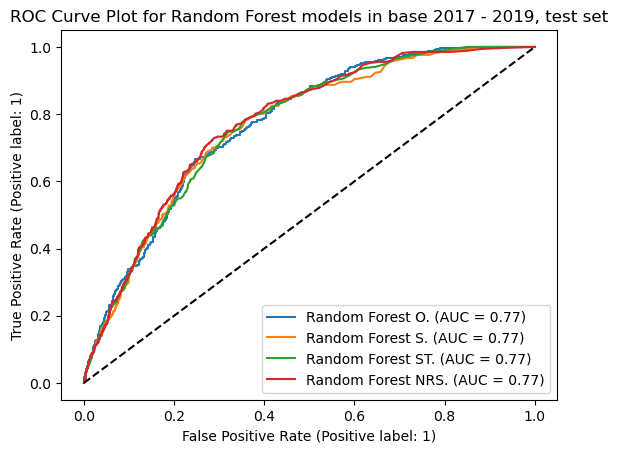

In [33]:
# Random Forest

fig, ax = plt.subplots()

metrics.plot_roc_curve( rf_optimal_model_o, x_test, y_test, ax = ax, name = 'Random Forest O.' )
metrics.plot_roc_curve( rf_optimal_model_s, x_test, y_test, ax = ax, name = 'Random Forest S.' )
metrics.plot_roc_curve( rf_optimal_model_st, x_test, y_test, ax = ax, name = 'Random Forest ST.' )
metrics.plot_roc_curve( rf_optimal_model_nrs, x_test, y_test, ax = ax, name = 'Random Forest NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Random Forest models in base 2017 - 2019, test set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_2\plots\base_17_19\base_17_19_roc_curve_rf_test.jpg', dpi = 300, bbox_inches = 'tight' )

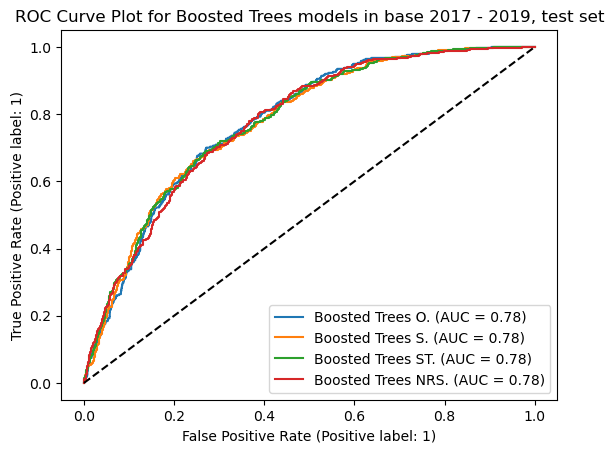

In [34]:
# Boosted Trees

fig, ax = plt.subplots()

metrics.plot_roc_curve( xgb_optimal_model_o, x_test, y_test, ax = ax, name = 'Boosted Trees O.' )
metrics.plot_roc_curve( xgb_optimal_model_s, x_test, y_test, ax = ax, name = 'Boosted Trees S.' )
metrics.plot_roc_curve( xgb_optimal_model_st, x_test, y_test, ax = ax, name = 'Boosted Trees ST.' )
metrics.plot_roc_curve( xgb_optimal_model_nrs, x_test, y_test, ax = ax, name = 'Boosted Trees NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Boosted Trees models in base 2017 - 2019, test set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_2\plots\base_17_19\base_17_19_roc_curve_xgb_test.jpg', dpi = 300, bbox_inches = 'tight' )

### 8.2. Training set

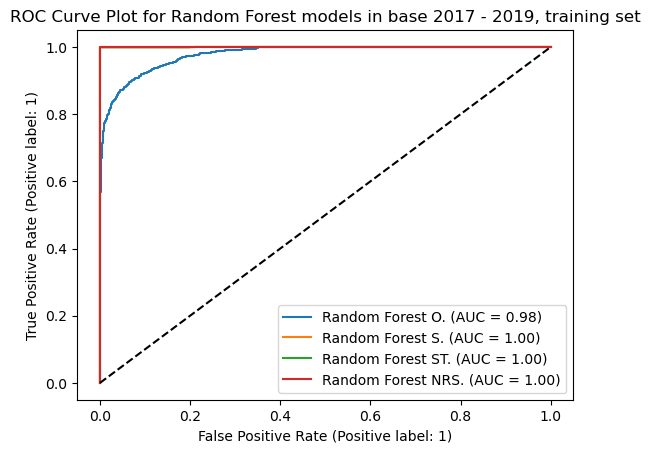

In [35]:
# Random Forest

fig, ax = plt.subplots()

metrics.plot_roc_curve( rf_optimal_model_o, x_train, y_train, ax = ax, name = 'Random Forest O.' )
metrics.plot_roc_curve( rf_optimal_model_s, x_train, y_train, ax = ax, name = 'Random Forest S.' )
metrics.plot_roc_curve( rf_optimal_model_st, x_train, y_train, ax = ax, name = 'Random Forest ST.' )
metrics.plot_roc_curve( rf_optimal_model_nrs, x_train, y_train, ax = ax, name = 'Random Forest NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Random Forest models in base 2017 - 2019, training set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_2\plots\base_17_19\base_17_19_roc_curve_rf_training.jpg', dpi = 300, bbox_inches = 'tight' )

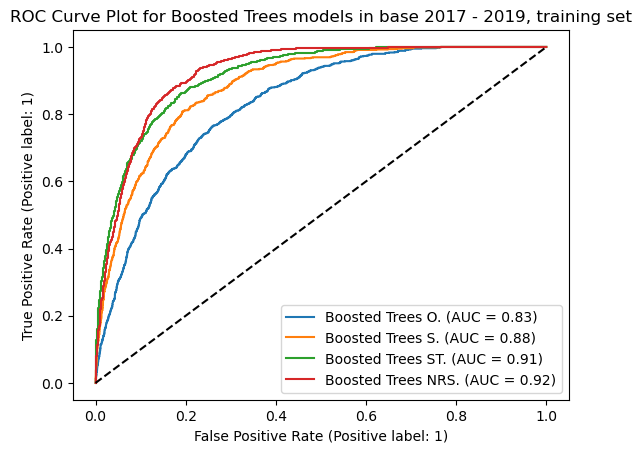

In [36]:
# Boosted Trees

fig, ax = plt.subplots()

metrics.plot_roc_curve( xgb_optimal_model_o, x_train, y_train, ax = ax, name = 'Boosted Trees O.' )
metrics.plot_roc_curve( xgb_optimal_model_s, x_train, y_train, ax = ax, name = 'Boosted Trees S.' )
metrics.plot_roc_curve( xgb_optimal_model_st, x_train, y_train, ax = ax, name = 'Boosted Trees ST.' )
metrics.plot_roc_curve( xgb_optimal_model_nrs, x_train, y_train, ax = ax, name = 'Boosted Trees NRS.' )

plt.plot( [ 0, 1 ], [ 0, 1 ], 'k--' )

ax.set_title( 'ROC Curve Plot for Boosted Trees models in base 2017 - 2019, training set')
ax.legend( loc = 'lower right' )

plt.savefig( r'..\..\..\output\ejecucion_2\plots\base_17_19\base_17_19_roc_curve_xgb_training.jpg', dpi = 300, bbox_inches = 'tight' )

## 9. Save models

In [37]:
joblib.dump( rf_optimal_model_o, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_rf_o.joblib' )
joblib.dump( rf_optimal_model_s, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_rf_s.joblib' )
joblib.dump( rf_optimal_model_st, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_rf_st.joblib' )
joblib.dump( rf_optimal_model_nrs, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_rf_nrs.joblib' )

joblib.dump( xgb_optimal_model_o, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_xgb_o.joblib' )
joblib.dump( xgb_optimal_model_s, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_xgb_s.joblib' )
joblib.dump( xgb_optimal_model_st, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_xgb_st.joblib' )
joblib.dump( xgb_optimal_model_nrs, r'..\..\..\output\ejecucion_2\models\base_17_19\base_17_19_xgb_nrs.joblib' )

['..\\..\\..\\output\\ejecucion_2\\models\\base_17_19\\base_17_19_xgb_nrs.joblib']

## 13. Grid Search Results

In [38]:
# Store Grid Search Results for Random Forest
results_gs_rf_o    = pd.DataFrame( rf_search_o.cv_results_ )
results_gs_rf_s    = pd.DataFrame( rf_search_s.cv_results_ )
results_gs_rf_st   = pd.DataFrame( rf_search_st.cv_results_ )
results_gs_rf_nrs  = pd.DataFrame( rf_search_nrs.cv_results_ )

# Store Grid Search Results for Boosted Trees
results_gs_xgb_o   = pd.DataFrame( xgb_search_o.cv_results_ )
results_gs_xgb_s   = pd.DataFrame( xgb_search_s.cv_results_ )
results_gs_xgb_st  = pd.DataFrame( xgb_search_st.cv_results_ )
results_gs_xgb_nrs = pd.DataFrame( xgb_search_nrs.cv_results_ )

In [39]:
# Save Grid Search Results for Random Forest
results_gs_rf_o.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_rf_o.xlsx' )
results_gs_rf_s.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_rf_s.xlsx' )
results_gs_rf_st.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_rf_st.xlsx' )
results_gs_rf_nrs.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_rf_nrs.xlsx' )

# Save Grid Search Results for Boosted Trees
results_gs_xgb_o.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_xgb_o.xlsx' )
results_gs_xgb_s.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_xgb_s.xlsx' )
results_gs_xgb_st.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_xgb_st.xlsx' )
results_gs_xgb_nrs.to_excel( r'..\..\..\output\ejecucion_2\gridsearch_results\base_17_19\base_17_19_results_gs_xgb_nrs.xlsx' )

## 14. Features maps

In [40]:
# Random Forest (Original) 
fp_randomforest_o = pd.Series( rf_optimal_model_o.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_o = pd.DataFrame( fp_randomforest_o.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [41]:
# Random Forest (SMOTE)
fp_randomforest_s = pd.Series( rf_optimal_model_s.feature_importances_, index = pred_vars ).\
                    sort_values( ascending = False )

fp_randomforest_s = pd.DataFrame( fp_randomforest_s.head( 50 ) ).\
                                  reset_index().\
                                  rename( columns = { 'index': 'vars', 0: 'score' } )

In [42]:
# Random Forest (SMOTE Tomek)
fp_randomforest_st = pd.Series( rf_optimal_model_st.feature_importances_, index = pred_vars ).\
                     sort_values( ascending = False )

fp_randomforest_st = pd.DataFrame( fp_randomforest_st.head( 50 ) ).\
                                   reset_index().\
                                   rename( columns = { 'index': 'vars', 0: 'score' } )

In [43]:
# Random Forest (NRS)
fp_randomforest_nrs = pd.Series( rf_optimal_model_nrs.feature_importances_, index = pred_vars ).\
                      sort_values( ascending = False )

fp_randomforest_nrs = pd.DataFrame( fp_randomforest_nrs.head( 50 ) ).\
                                    reset_index().\
                                    rename( columns = { 'index': 'vars', 0: 'score' } )

In [44]:
# Boosted Trees (Original)
fp_xgboost_o = pd.Series( xgb_optimal_model_o.feature_importances_, index = pred_vars ).\
           sort_values( ascending = False )

fp_xgboost_o = pd.DataFrame( fp_xgboost_o.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [45]:
# Boosted Trees (SMOTE)
fp_xgboost_s = pd.Series( xgb_optimal_model_s.feature_importances_, index = pred_vars ).\
               sort_values( ascending = False )

fp_xgboost_s = pd.DataFrame( fp_xgboost_s.head( 50 ) ).\
                             reset_index().\
                             rename( columns = { 'index': 'vars', 0: 'score' } )

In [46]:
# Boosted Trees (SMOTE Tomek)
fp_xgboost_st = pd.Series( xgb_optimal_model_st.feature_importances_, index = pred_vars ).\
                sort_values( ascending = False )

fp_xgboost_st = pd.DataFrame( fp_xgboost_st.head( 50 ) ).\
                              reset_index().\
                              rename( columns = { 'index': 'vars', 0: 'score' } )

In [47]:
# Boosted Trees (NRS)
fp_xgboost_nrs = pd.Series( xgb_optimal_model_nrs.feature_importances_, index = pred_vars ).\
                 sort_values( ascending = False )

fp_xgboost_nrs = pd.DataFrame( fp_xgboost_nrs.head( 50 ) ).\
                               reset_index().\
                               rename( columns = { 'index': 'vars', 0: 'score' } )

## 15. Export results

In [48]:
# Variables Random Forest

fp_randomforest_o.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_rf_o.xlsx' )
fp_randomforest_s.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_rf_s.xlsx' )
fp_randomforest_st.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_rf_st.xlsx' )
fp_randomforest_nrs.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_rf_nrs.xlsx' )

In [49]:
# Variables Boosted Trees

fp_xgboost_o.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_xgb_o.xlsx' )
fp_xgboost_s.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_xgb_s.xlsx' )
fp_xgboost_st.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_xgb_st.xlsx' )
fp_xgboost_nrs.to_excel( r'..\..\..\output\ejecucion_2\results\base_17_19\base_17_19_xgb_nrs.xlsx' )